# 20190409
## Implementing with filtering and thresholding

For now inherit the ugly LSM class and inherit it in the Filter class (to be changed later). Operate with the LSM class to obtain the first rgb.tiff output.

Filter class has the median filter and otsu thresolding as an initial test

In [6]:

import os
from skimage.external import tifffile as tf
import numpy as np
import scipy.signal
from skimage import data, filters
import matplotlib.pyplot as plt # plt.imshow()


def main():
    os.chdir("/home/c/Documents/Academic/BI3002 Biosciences Erasmus "
             "Placement Research Project/CellCounter")
    tifobj = tf.TiffFile("testack.lsm")
    arr = tifobj.asarray()
    return arr


class LSM:

    def __init__(self):
        self.red_sum = {}
        self.green_sum = {}
        self.blue_sum = {}
        self.red_max = {}
        self.green_max = {}
        self.blue_max = {}

    def project_channel_sum(channelid):
        """ Takes a 6 dimensions tiff array and projects the Z axis into X, Y.
        Uses the max intensity value of each Z slice.
        """
        arr = main()
        channel_sum = np.zeros((512, 512), dtype=np.int8)
        for i in range(0, np.size(arr, 2)):
            channel_sum = np.add(channel_sum, arr[0, 0, i, channelid, :, :])
        # Normalize, first 0 - 1, then to max = 255 (uint8)
        channel_sum = channel_sum.astype(np.float64) / channel_sum.max()
        channel_sum = 255 * channel_sum
        channel_sum = channel_sum.astype(np.uint8)
        return channel_sum

    def project_channel_max(channelid):
        """ Takes a 6 dimensions tiff array and projects the Z axis into X, Y.
        Uses the max intensity value of each Z slice.
        """
        arr = main()
        channel_max = np.zeros((512, 512), dtype=np.int8)
        for i in range(0, np.size(arr, 2)):
            channel_max = np.fmax(channel_max, arr[0, 0, i, channelid, :, :],
                                  dtype=np.int8)
        # Normalize, first 0 - 1, then to max = 255
        channel_max = channel_max.astype(np.float64) / channel_max.max()
        channel_max = 255 * channel_max
        channel_max = channel_max.astype(np.uint8)
        return channel_max

    red_sum = project_channel_sum(0)
    green_sum = project_channel_sum(1)
    blue_sum = project_channel_sum(2)

    red_max = project_channel_max(0)
    green_max = project_channel_max(1)
    blue_max = project_channel_max(2)


lsm1 = LSM

rgb = np.dstack([lsm1.red_max,    # R
                 lsm1.green_max,  # G
                 lsm1.blue_max])  # B

rgb = np.moveaxis(rgb, -1, 0)

tf.imsave('rgb.tiff', rgb)


class Filter(LSM):
    '''
    Carlos, ten en cuenta que el efecto de los filtros depende de la forma y tamaño de los 'kernels' o
    'structuring elements'. Por defecto se usan un 'disco' de 1pxl de diametro, creo.
    Es posible que algo de experimentación con el tamaño de un disco fuera conveniente.

    Puedes probar
    from skimage.morphology import disk
    diameter = something between 5 and 20 to start with?
    strel = disk(diameter)
    '''
    
    def __init__(self):
        pass

    def median_filter(volume):
        filtered = scipy.signal.medfilt(volume)
#        filtered = filters.median(volume, strel)
        return filtered

    def otsu_thesholding(image):
        thresholded = image > filters.threshold_otsu(image)
        return thresholded


arr = main()


Let's show the original DAPI channel from the z projected image to compare with the filtered version:

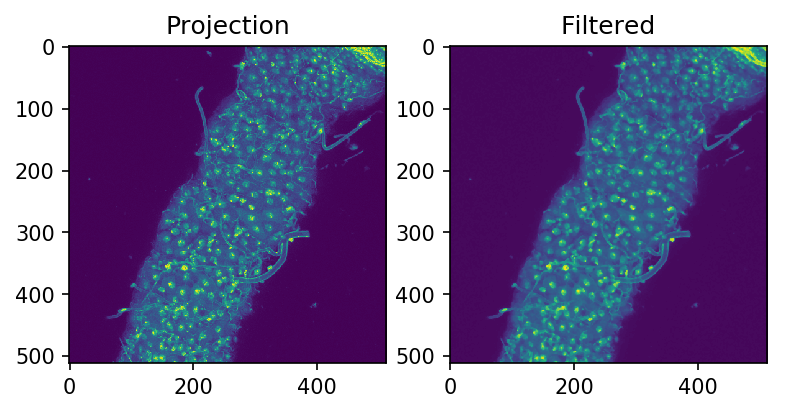

In [7]:
projected = rgb[2,:,:]

arr = main()
lsm1 = Filter
filtered = lsm1.median_filter(rgb[2,:,:])


fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150)

ax[0].imshow(projected)
ax[0].set_title('Projection')

ax[1].imshow(filtered)
ax[1].set_title('Filtered')

plt.show()

Roughness is indeed reduced



Now plot first otsu thresholded image:

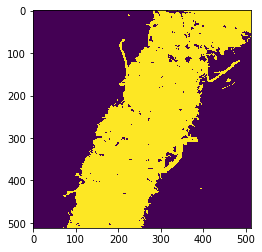

In [47]:
"""JQ: This is not entirely surprising, as there is a LOT of background.
perhaps a multi-treshold would work but I doubt it.
Perhaps a possibility would be to use this as a a mask, and pass the masked array
to the otsu thresholding to get another threshold between the nuclei and the background
Or use a different treshold, I will need to think a bit about which one...
or use the blob analysis thing that is in the notebook I sent you"""

thresholded = lsm1.otsu_thesholding(filtered)
plt.imshow(thresholded)


Output is not very beautiful nor informative, I tried different approaches before swapping to another method. As the otsu function only returns a value to be used in the actual thresholding oeration, it may be used to generate dynamic thresholding behavior inside other functions. I explored another basic thresholding, hysteresis thresholding:

http://scikit-image.org/docs/stable/auto_examples/filters/plot_hysteresis.html#sphx-glr-auto-examples-filters-plot-hysteresis-py

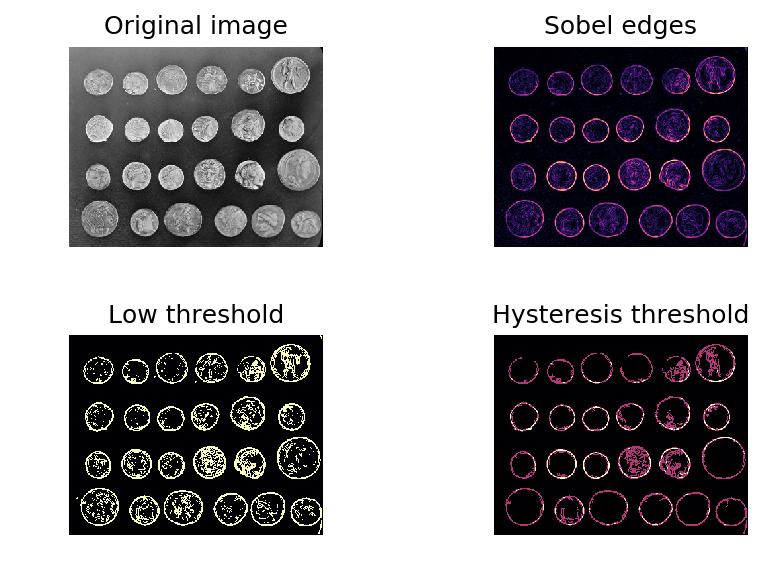

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, dpi=150)

image = data.coins()
edges = filters.sobel(image)

low = 0.1
high = 0.35

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

Hysteresis thresholding need an array and two vales as input. As not all images look overall the same, a fixed threshold will not likely work for all of them. Hysteresis thresholding could be made more "image-sensitive" combined with otsu filtering.

The following code will find out the otsu threshold for an area with reduced background (this was just a rough test), apply a +70% otsu threshold as the minimum for the hysteresis thresholding function. The maximum for hystheresis thresholding will be dynamically determined by the maximum intensity of the filtered image (-45% of that value).

Also, would it make any difference to try and work with the raw z-project?

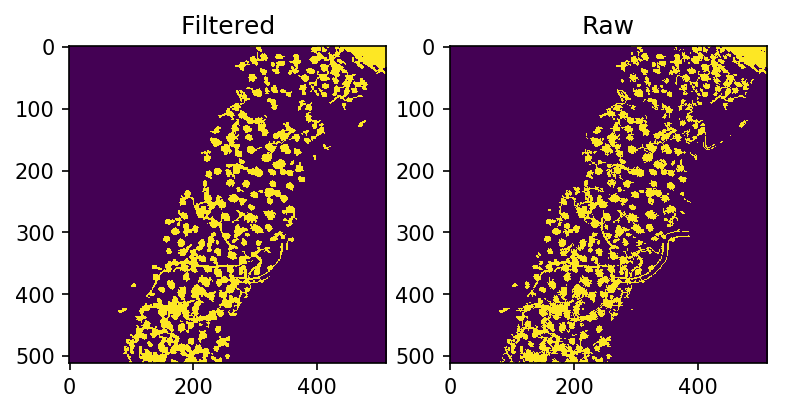

In [11]:
'''
I think this threshold is mostly to detect boundaries rather than blobs, but it seems to work!
'''


processed1 = filters.apply_hysteresis_threshold(
        filtered,filters.threshold_otsu(filtered[:, 150:350]) * 1.7,
        np.max(filtered) * 0.55)

processed2 = filters.apply_hysteresis_threshold(
        projected, filters.threshold_otsu(filtered[:, 150:350]) * 1.7,
        np.max(filtered) * 0.55)

"""JQ: what's the difference between these two???"""
"""C: my bad, fixed now"""


fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150)
ax[0].imshow(processed1)
ax[0].set_title('Filtered')

ax[1].imshow(processed2)
ax[1].set_title('Raw')

plt.show()

Better but still far from reality. I tried some operations about changing otsu value for a number obtained playing with the median in certain image regions but results were worse. It looks like working with the unfiltered image is not worth it.

Playing with hysteresis min and max argument value multiplier can get a better result. However, will this fine tunning translate into other images?

'''
you are right about this, I didn't think the Hoechst signal would be so high in the tissue outside the nuclei.
I think you should try using masked arrays (numpy.ma module), so you can reapply the otsu threshold (or others)
to the pixel values within the large blob you detected initially.

Also, this is far from reality but we can start doing some improvement post-binarisation doing
some morphological filtering:
http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html
(i'm thinking some simple closing but perhaps some tophat would be helpful with this amount of background)

...and then watershed (watershed is very sensitive to the shape of the edge of objects so some
rounding of the edges is necessary through morphological filtering)
http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

you could also try a completely different threshold, testing all the ones implemented in scikit image using
try_all_threshold :
http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html

I also have an implementation of two other thresholds you might want to test, see below
'''

def threshold_triangle(img,bit_depth):
    '''
    TRANSLATED FROM THE MATLAB UPLOAD BY B. PANNETON:
        
    Triangle algorithm
    
    This technique is due to Zack (Zack GW, Rogers WE, Latt SA (1977), 
    "Automatic measurement of sister chromatid exchange frequency", 
    J. Histochem. Cytochem. 25 (7): 741-53, )
    
    A line is constructed between the maximum of the histogram at 
    (b) and the lowest (or highest depending on context) value (a) in the 
    histogram. The distance L normal to the line and between the line and 
    the histogram h[b] is computed for all values from a to b. The level
    where the distance between the histogram and the line is maximal is the 
    threshold value (level). This technique is particularly effective 
    when the object pixels produce a weak peak in the histogram.
    
    Use Triangle approach to compute threshold (level) based on a
    1D histogram (lehisto). num_bins levels gray image. 
    
    INPUTS
        lehisto :   histogram of the gray level image
        num_bins:   number of bins (e.g. gray levels)
    OUTPUT
        level   :   threshold value in the range [0 1];

    Dr B. Panneton, June, 2010
    Agriculture and Agri-Food Canada
    St-Jean-sur-Richelieu, Qc, Canad
    bernard.panneton@agr.gc.ca
    '''
    
    from skimage.exposure import histogram
    
    try:
        bit_depth
        if bit_depth not in [8,16]:
            raise Warning('''The bit depth must take one of the values: 8, 16.
            The image will be considered as 8-bit.''')
            num_bins=256
        else:
            num_bins = np.power(2,bit_depth)
    except:
        print('The image will be considered as 8-bit.')
        num_bins=256
    
    # Find maximum of histogram (h) and its location along the x axis (xmax)
    try:
        data = img.flatten().data[img.flatten().mask==True]
        [H,bin_centres]=(histogram(data,nbins = num_bins));
    except:
        [H,bin_centres]=(histogram(img.flatten(),nbins = num_bins));

    if len(H)<num_bins:
       num_bins = len(H)
     #  print() '''................................................................................
WARNING (jqtricks.threshold_triangle): Not all possible bins contain data,
num_bins will be reduced to reflect this.
''' 
    xmax_idx = np.where(H==np.max(H))[0]
    h = np.mean(H[xmax_idx])
    # LET'S ASSUME THERE IS ONLY ONE xmax_idx:
    xmax_idx = xmax_idx[0]
    #xmax = np.mean(bin_centres[np.array(xmax_idx)])
    
    ## VISUAL CHECK
    #import matplotlib.pyplot as plt
    #n, bins, patches = plt.hist(img.flatten(), num_bins, normed=2, facecolor='green', alpha=0.5)
    #y = range((h+h/20).astype('int'))
    #plt.plot(np.ones(len(y)*xmax), y, 'r--')
    #plt.show()
    
    # Find location of first and last non-zero values.
    indi=np.where(H>(h/10000))[0]         # Values<h/10000 are considered zeros
    #indi=np.where(H>0)[0]
    fnz=indi[0]
    lnz=indi[-1]

    # Pick side as side with longer tail. Assume one tail is longer.
    lspan=xmax_idx-fnz
    rspan=lnz-xmax_idx
    if rspan>lspan:  # then flip lehisto
        H=np.fliplr(H.reshape([1,len(H)]))[0]
        bin_centres=np.fliplr(bin_centres.reshape([1,len(bin_centres)]))[0]
        a=num_bins-(lnz+1)
        b=num_bins-xmax_idx
        isflip=1
    else:
        isflip=0
        a=fnz
        b=xmax_idx+1
    
    # Compute parameters of the straight line from first non-zero to peak
    # To simplify, shift x axis by a (bin number axis)
    m=h/(b-a)
    
    # Compute distances
    x1=range((b-a).astype('int'))
    y1=H[x1+a]
    beta=y1+x1/m
    x2=beta/(m+1/m)
    y2=m*x2
    #from matplotlib.pyplot import plot
    #plot(x2,y2,'gD-')
    #plot(x1,y1,'mo-')
    L=np.sqrt(np.square(y2-y1)+np.square(x2-x1))

    # Obtain threshold as the location of maximum L.    
    level=np.where(L==np.max(L))[0]
    level=a+np.mean(level)
    
    # Flip back if necessary
    if isflip:
        level=num_bins-level+1

    return level

def threshold_entropy(image, nbins=256):
    """Return threshold value based on the Maximum Entropy method, similar to
    Otsu's method but maximizing inter-class entropy as S = -(sum)p*log2(p).
    """
    from skimage.exposure import histogram
    H, bin_centers = histogram(image, nbins)
    H = H.astype(float)
    if (H==0).sum() > 0:
        H[H==0] = np.min(H[H>0])/float(10)
        
    # class probabilities for all possible thresholds
    weight1 = np.cumsum(H)
    weight2 = np.cumsum(H[::-1])[::-1]
    
    # class means for all possible thresholds
    entpy1 = np.cumsum(-(H/weight1)*np.log2(H/weight1))
    entpy2 = np.cumsum(-(H[::-1]/weight2[::-1])*np.log2(H[::-1]/weight2[::-1]))[::-1]

    # maximum entropy
    entpy_sum = entpy1 + entpy2

    idx = np.argmax(entpy_sum)
    threshold = bin_centers[:-1][idx]
    return threshold

# 20190411

## Experimenting with filtering

Changed "filtered = scipy.signal.medfilt(volume)" for "filtered = filters.median(volume, strel)". Plot comparing the use of different disk sizes.

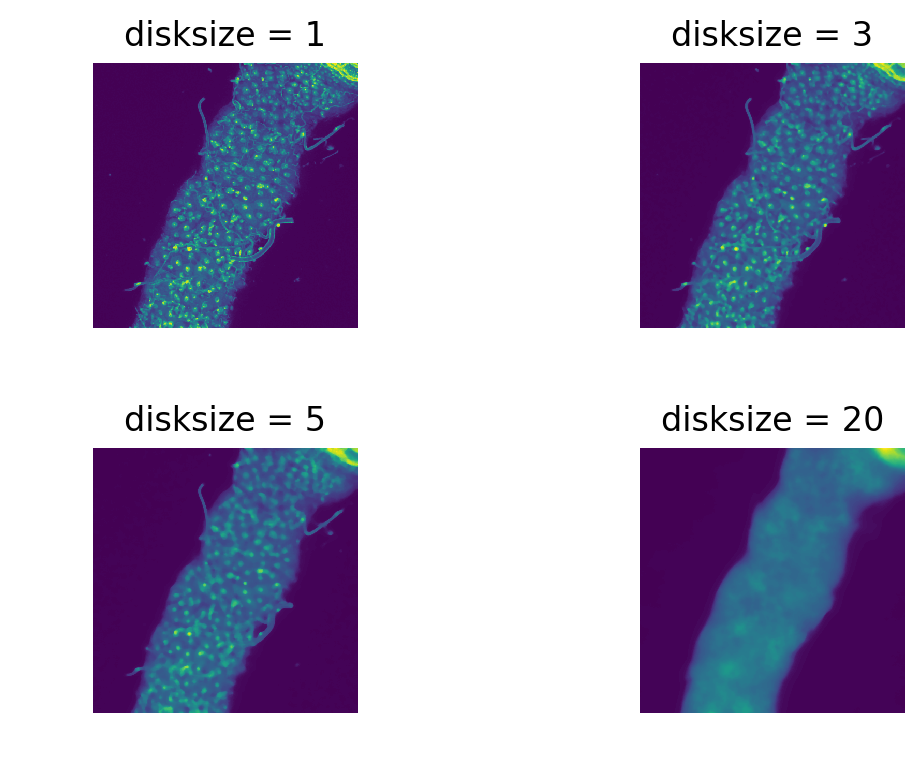

In [130]:
from skimage.morphology import disk

# PREV JQ: diameter = something between 5 and 20 to start with?

def filtering(disksize):
    filtered = filters.median(projected, disk(disksize))
    return filtered


fig, axes = plt.subplots(nrows=2, ncols=2, dpi = 200)

ax = axes.ravel()
titles = ['disksize = 1', 'disksize = 3', 'disksize = 5', 'disksize = 20']

imgs = [filtering(1), filtering(3), filtering(5), filtering(20)]

for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n])
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()


It made sense a bigger disk size could give better results but IMO it wasn't the case.

## Blob analysis
"""PREV JQ: This is not entirely surprising, as there is a LOT of background.

Perhaps a multi-treshold would work but I doubt it.

Perhaps a possibility would be to use this (C: SIMPLE OTSU) as a a mask, and pass the masked array to the otsu thresholding to get another threshold between the nuclei and the background.

Or use a different treshold, I will need to think a bit about which one...

or _**use the blob analysis thing**_ that is in the notebook I sent you"""

The notebook seems more evaluation-centered, I will test the different blob detection methods from scikit.

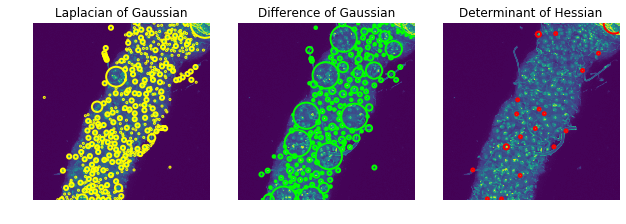

In [67]:
"""Taken from http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html"""

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray


image = filtered
# image_gray = rgb2gray(image) not needed

blobs_log = blob_log(image, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

Laplacian of Gaussian seems the one we want to use because a) it is the most accurate although computationally expensive (http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html), b) seems to give good results in this very preliminar test

Regarding a), this one image wasn't a challenge for my small laptop. We shold see as we scale all this up.

Trying to optimize parameters:

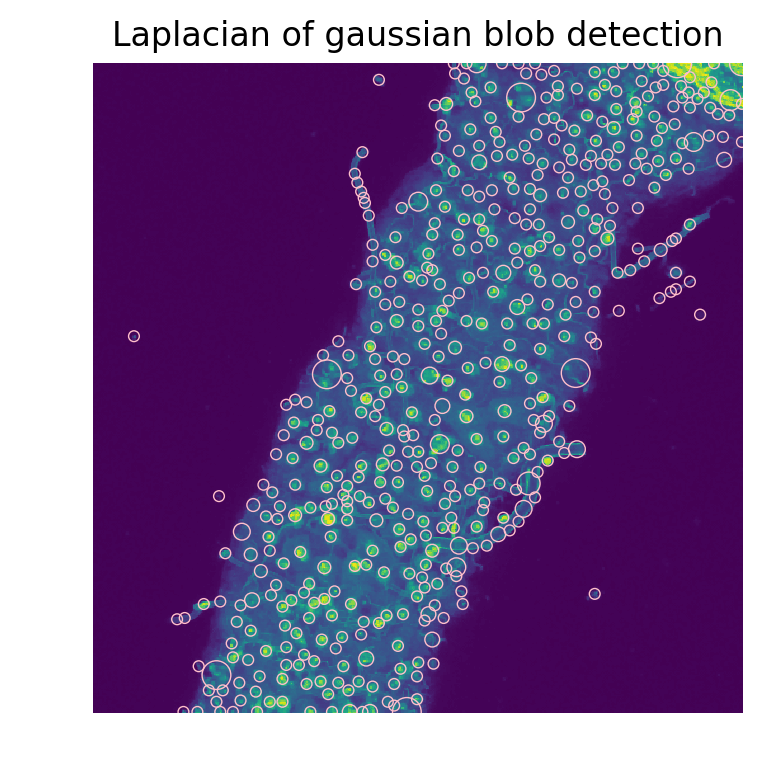

In [156]:
blobs_log = blob_log(image, min_sigma=3, max_sigma=8, threshold=.035) #, num_sigma=10

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(1, 1, dpi = 200, sharex=True, sharey=True)

ax.set_title("Laplacian of gaussian blob detection")
ax.imshow(image, interpolation='nearest')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="pink", linewidth=0.5, fill=False)
    ax.add_patch(c)
ax.set_axis_off()

plt.tight_layout()
plt.show()

Problem with false positives, specially bad but easy to fix in the case of the blobs outside the gut (use mask). Harder to fix in the case of the tracheas. Can play with the threshold parameter of "blob_log" but again manual fine tunning is not the best option.

## Masked arrays
"PREV JQ: I think you should try using masked arrays (numpy.ma module), so you can reapply the otsu threshold (or others) to the pixel values within the large blob you detected initially."

Test of a simple mask operation just to see it working:

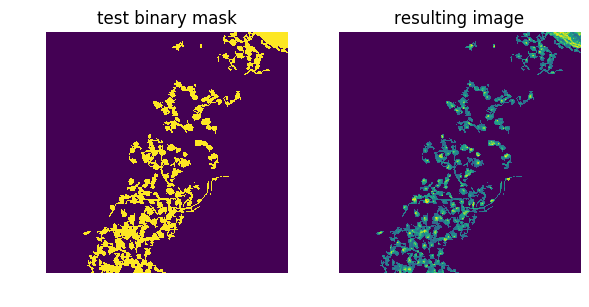

In [153]:
filtered = filters.median(projected, disk(1)) # (slightly)Updated filtering strategy

thresholded = filters.apply_hysteresis_threshold(filtered, np.min(filtered)*20, np.max(filtered)*0.9)
# obtain a test binary mask

masked = filtered * thresholded # apply mask

fig, axes = plt.subplots(1, 2, dpi = 100)

ax = axes.ravel()
titles = ['test binary mask', 'resulting image']

imgs = [thresholded, masked]

for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n])
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()




It works. Now apply a much more subtle mask that separates the gut from the rest:

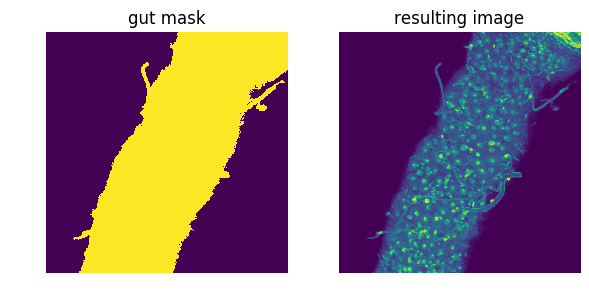

In [154]:
thresholded = filters.apply_hysteresis_threshold(filtered, np.min(filtered)*2, np.max(filtered)*0.9)
# obtain a gut binary mask

masked = filtered * thresholded

fig, axes = plt.subplots(1, 2, dpi = 100)

ax = axes.ravel()
titles = ['gut mask', 'resulting image']

imgs = [thresholded, masked]

for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n])
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()

Mask could be improved but at least removes part of the noise that wasn't doing any good to the segmentation strategies.

Now back to laplacian blob detection.

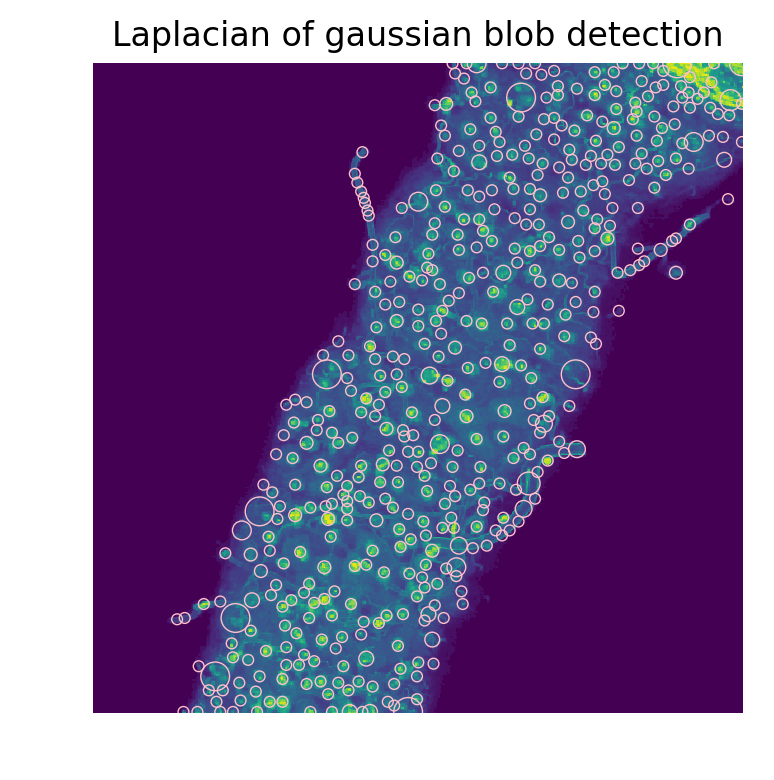

In [157]:
blobs_log = blob_log(masked, min_sigma=3, max_sigma=8, threshold=.035) #, num_sigma=10

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(1, 1, dpi = 200, sharex=True, sharey=True)

ax.set_title("Laplacian of gaussian blob detection")
ax.imshow(masked, interpolation='nearest')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="pink", linewidth=0.5, fill=False)
    ax.add_patch(c)
ax.set_axis_off()

plt.tight_layout()
plt.show()

/home/c/.local/lib/python3.6/site-packages/scipy/cluster/vq.py:580: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/home/c/.local/lib/python3.6/site-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


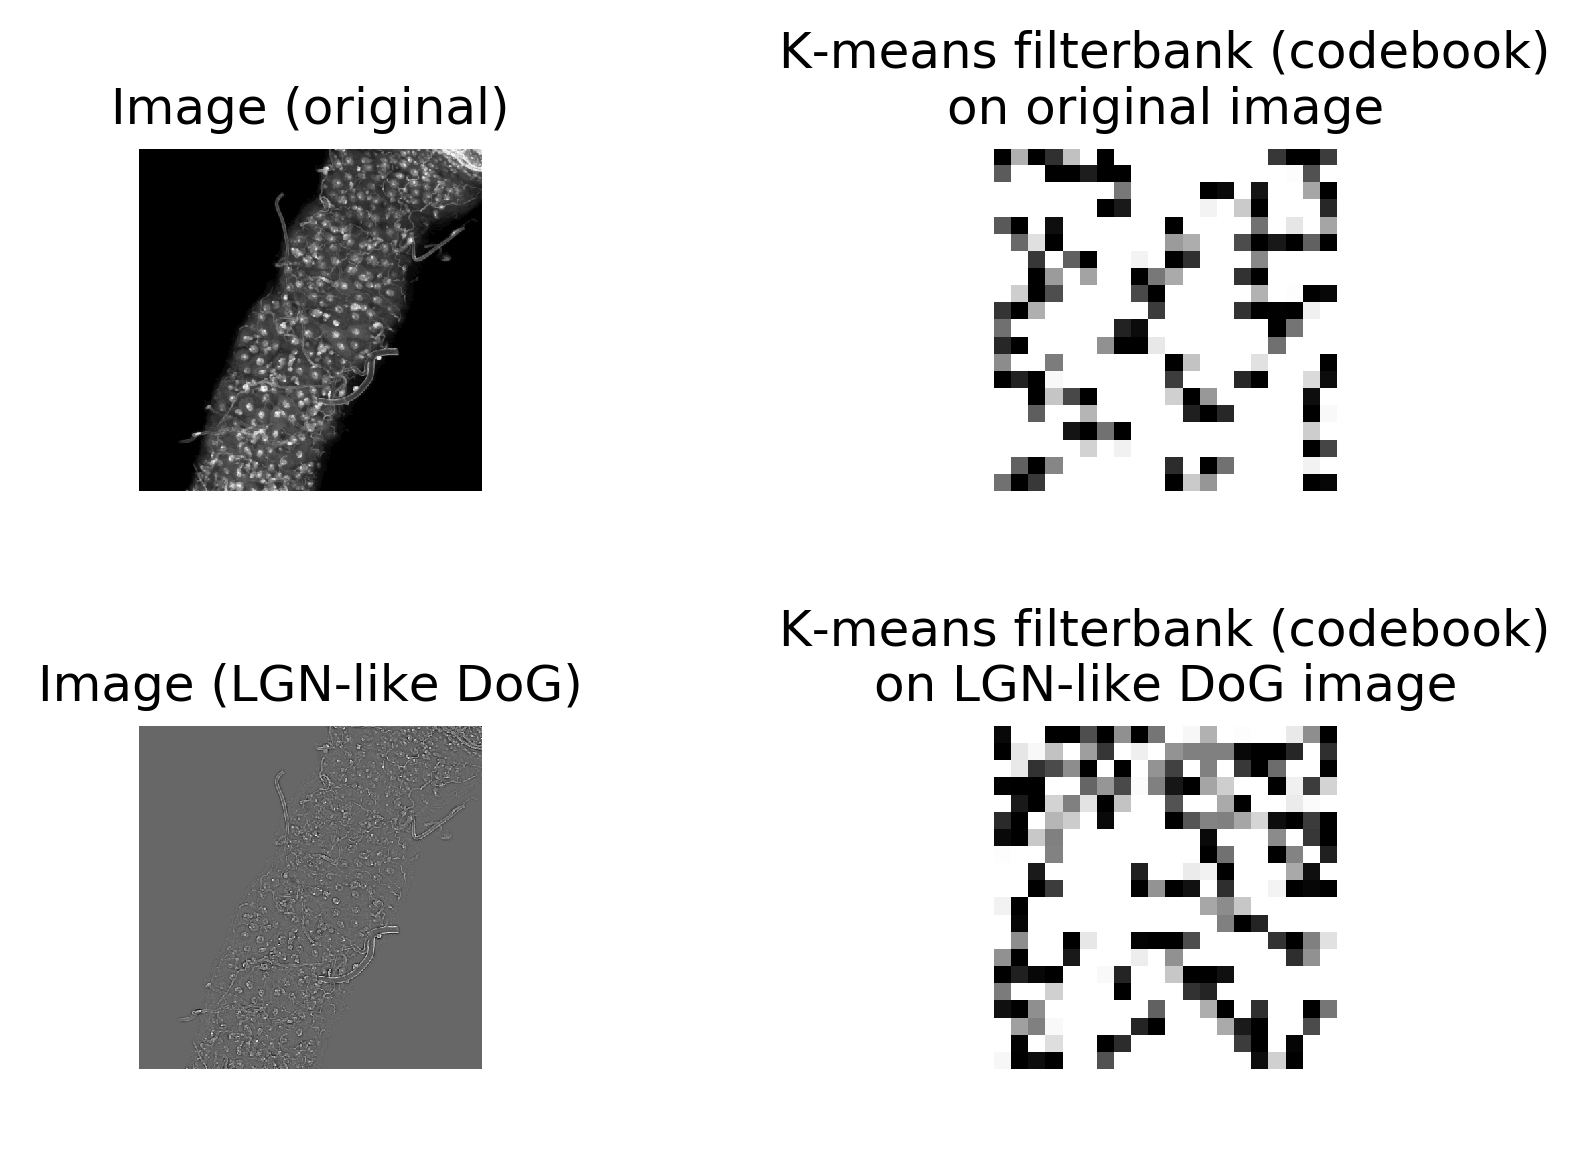

In [180]:
"""
I love gabor filters so why not try super fast
http://scikit-image.org/docs/dev/auto_examples/features_detection/
plot_gabor.html#sphx-glr-auto-examples-features-detection-plot-gabor-py"""
import numpy as np
from scipy.cluster.vq import kmeans2
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage.util.shape import view_as_windows
from skimage.util import montage

np.random.seed(42)

patch_shape = 2, 2
n_filters = 100

masked = masked.astype(np.float64)
astro = masked

# -- filterbank1 on original image
patches1 = view_as_windows(astro, patch_shape)
patches1 = patches1.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb1, _ = kmeans2(patches1, n_filters, minit='points')
fb1 = fb1.reshape((-1,) + patch_shape)
fb1_montage = montage(fb1, rescale_intensity=True)

# -- filterbank2 LGN-like image
astro_dog = ndi.gaussian_filter(astro, .5) - ndi.gaussian_filter(astro, 1)
patches2 = view_as_windows(astro_dog, patch_shape)
patches2 = patches2.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb2, _ = kmeans2(patches2, n_filters, minit='points')
fb2 = fb2.reshape((-1,) + patch_shape)
fb2_montage = montage(fb2, rescale_intensity=True)

# -- plotting
fig, axes = plt.subplots(2, 2, dpi = 300)
ax = axes.ravel()

ax[0].imshow(astro, cmap=plt.cm.gray)
ax[0].set_title("Image (original)")

ax[1].imshow(fb1_montage, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title("K-means filterbank (codebook)\non original image")

ax[2].imshow(astro_dog, cmap=plt.cm.gray)
ax[2].set_title("Image (LGN-like DoG)")

ax[3].imshow(fb2_montage, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title("K-means filterbank (codebook)\non LGN-like DoG image")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()

/home/c/.local/lib/python3.6/site-packages/scipy/cluster/vq.py:580: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/home/c/.local/lib/python3.6/site-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


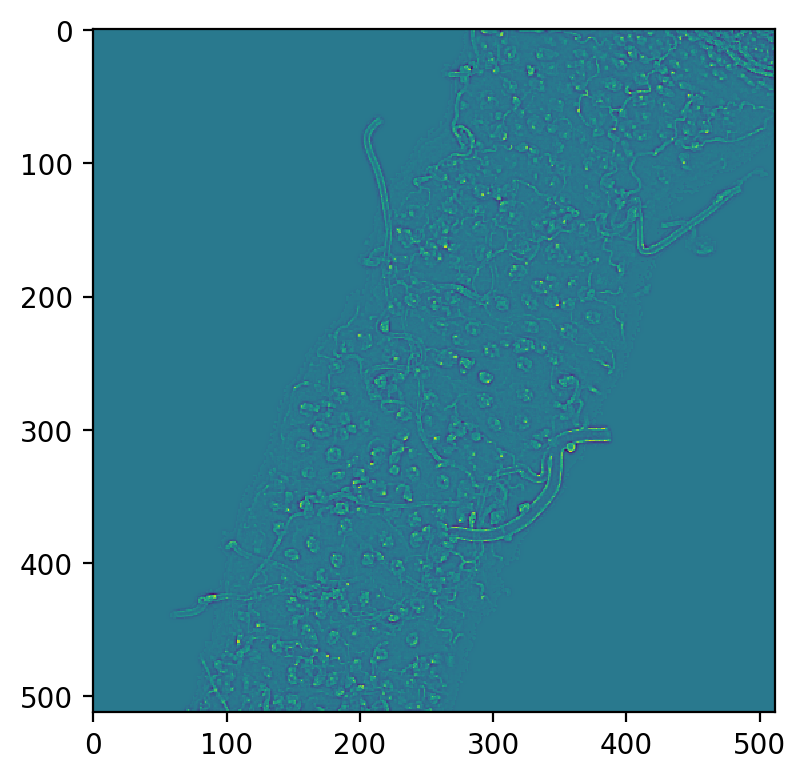

In [205]:
"""The difference of gaussians could be used for segmentation?"""
np.random.seed(42)

patch_shape = 2, 2
n_filters = 1000

masked = masked.astype(np.float64)
astro = masked

# -- filterbank1 on original image
patches1 = view_as_windows(astro, patch_shape)
patches1 = patches1.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb1, _ = kmeans2(patches1, n_filters, minit='points')
fb1 = fb1.reshape((-1,) + patch_shape)
fb1_montage = montage(fb1, rescale_intensity=True)

# -- filterbank2 LGN-like image
astro_dog = ndi.gaussian_filter(astro, .5) - ndi.gaussian_filter(astro, 1)
patches2 = view_as_windows(astro_dog, patch_shape)
patches2 = patches2.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb2, _ = kmeans2(patches2, n_filters, minit='points')
fb2 = fb2.reshape((-1,) + patch_shape)
fb2_montage = montage(fb2, rescale_intensity=True)


fig, ax = plt.subplots(1, 1, dpi = 200)

ax.set_title("")
ax.imshow(astro_dog, interpolation='nearest')#, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

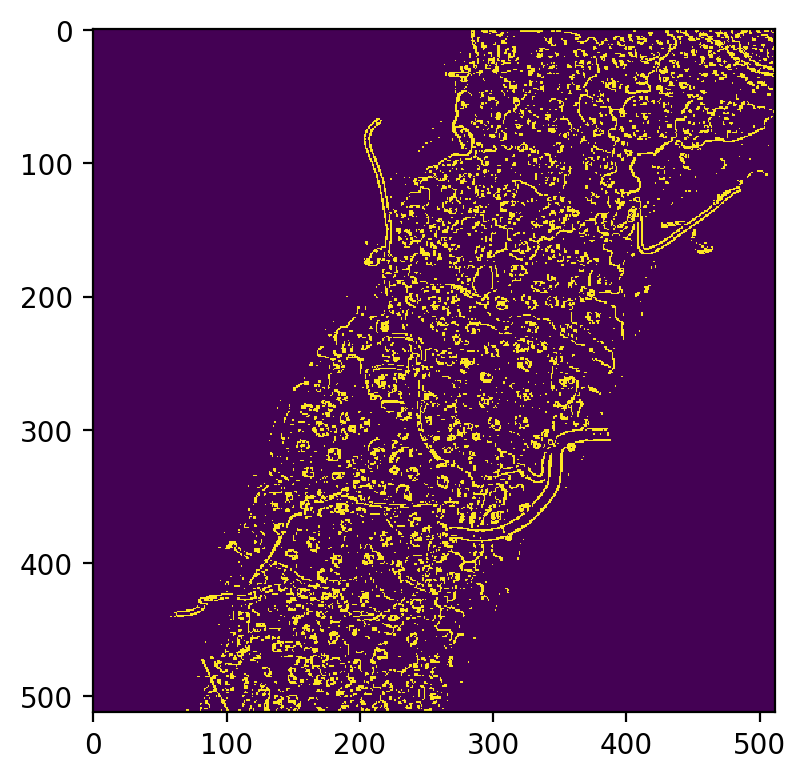

In [200]:


spam = astro_dog > (filters.threshold_otsu(astro_dog) - 2)


fig, ax = plt.subplots(1, 1, dpi = 200)

ax.set_title("")
ax.imshow(spam, interpolation='nearest')#, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

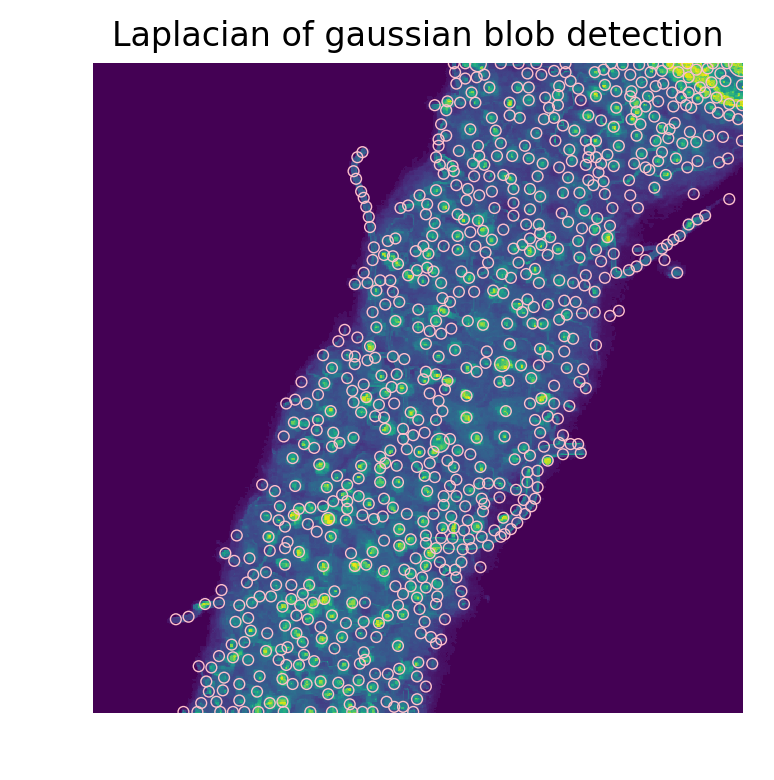

In [204]:
blobs_log = blob_log(astro_dog, min_sigma=3, max_sigma=8, threshold=1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(1, 1, dpi = 200, sharex=True, sharey=True)

ax.set_title("Laplacian of gaussian blob detection")
ax.imshow(masked, interpolation='nearest')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="pink", linewidth=0.5, fill=False)
    ax.add_patch(c)
ax.set_axis_off()

plt.tight_layout()
plt.show()

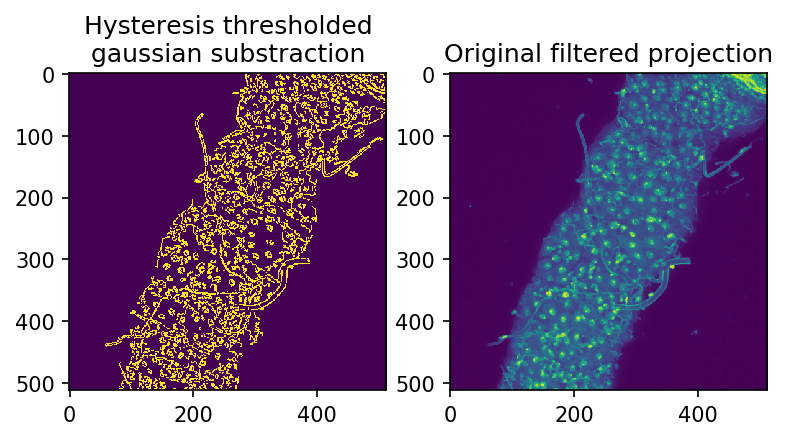

In [220]:
spam = filters.apply_hysteresis_threshold(astro_dog, 0, 7)


fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150)
ax[0].imshow(spam)
ax[0].set_title('Hysteresis thresholded\ngaussian substraction')

ax[1].imshow(filtered)
ax[1].set_title('Original filtered projection')

plt.show()

If only we could get rid of the tracheas